# Пайплайн для выделения лучших кропов по текстовому запросу Yolo -> Clip -> Annoy

Все расчеты ниже получены по **valid** выборке датасета LVIS

* Применяем модель YoloV5L к датасету, получаем кропы для картинок
* Применяем модель clip к каждому кропу, получаем эмбеддинги кропов
* Применяем модель clip к описанию категорий датасета LVIS, получаем эмбеддинги категорий
* Строим индекс annoy по эмбеддингам кропов для поиска ближайших соседей из кропов к каждой категории датасета
* Проводим анализ метрик

В дальнейшем полученный индекс annoy будет использоваться в ДЕМО для поиска подходящих кропов (из valid части датасета LVIS) для текстового запроса пользователя

In [2]:
ANNOY_SIZE = 'ScaNN'
import setproctitle
setproctitle.setproctitle(f"YOLO_{ANNOY_SIZE}")

In [3]:
import sys

sys.path.append("../yolov5")

In [4]:
from assh_utils import Batch, get_iou, load_json, nms

In [5]:
from yolo_utils import CustomWrapper, DetectMultiBackend

In [6]:
import os

root = "/home/asciishell/s3/asciishell-fsod/LVIS/"
js = load_json("/home/asciishell/s3/asciishell-fsod/LVIS/lvis_v1_val.json.zip")
images = [root + x["coco_url"].replace("http://images.cocodataset.org/", "") for x in js["images"]]
assert all([os.path.exists(x) for x in images[:100]])

In [7]:
import itertools
import math
import os
import pickle

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
from annoy import AnnoyIndex
from sklearn.cluster import KMeans
from sklearn.metrics import average_precision_score
from tqdm.cli import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
%matplotlib inline

cpu


In [8]:
embeddings = np.load("/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_emb.npy")
images = pd.read_pickle("/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid.done.pkl.zip")

In [9]:
categories_emb = np.load("/home/asciishell/s3/asciishell-fsod/RunYolo/categories_emb.npy")
categories = pd.read_pickle("/home/asciishell/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

In [11]:
import scann

2022-05-08 18:53:32.512557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asciishell/project/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-08 18:53:32.512593: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
embeddings

array([[   -0.02562,    0.070312,   -0.013474, ...,    0.088318,   0.0083847,   -0.036377],
       [  -0.049438,    0.029968,   -0.030914, ...,    0.073975,    0.013885,    0.029541],
       [ -0.0041504,    0.018295,   -0.027466, ...,    0.037659,   -0.011734,    0.017334],
       ...,
       [ -0.0027828,    0.032837,    0.010078, ...,     0.10553,    0.015518,    0.021378],
       [  -0.019791,    0.007122, -0.00077868, ...,     0.12915,    0.015961,    0.011101],
       [ -0.0060425,    0.024124,   0.0086746, ...,     0.09198,    0.028198,  -0.0060196]], dtype=float16)

In [19]:
searcher = (
    scann.scann_ops_pybind.builder(embeddings, 10, "dot_product")
    .tree(num_leaves=2000, num_leaves_to_search=100, training_sample_size=250000)
    .score_ah(2, anisotropic_quantization_threshold=0.2)
    .reorder(100)
    .build()
)

[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-05-08 18:55:46.891592: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 249532
2022-05-08 18:55:56.914902: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 10.02322841s.


## Проводим анализ метрик
Определим, относятся ли в действительности выделенные кропы к заданной категории (с помощью iou) и вычислим метрики качества.

In [22]:
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

In [23]:
metrics = []
annotation = pd.DataFrame(js['annotations'])
for index, category in tqdm(categories.iterrows(), total=categories.shape[0]):
    best = searcher.search(categories_emb[index], 30) # сколько есть максимально объектов каждой категории:
    x_conf = images.loc[best[0], 'confidence']
    tp = []
    x_iou = []
    for x in best[0]: # имеет ли смысл убрать кропы с одной картинки с большим iou?
        img = images.loc[x]
        for ann in annotation[annotation['image_id'] == int(img['image'][-16:-4])].iterrows():
            ann = ann[1]
            iou = get_iou({'x1': img['xmin'], 'x2': img['xmax'], 'y1': img['ymin'], 'y2': img['ymax']}, 
                    {'x1': ann['bbox'][0], 'x2': ann['bbox'][0] + ann['bbox'][2], 'y1': ann['bbox'][1], 'y2': ann['bbox'][1] + ann['bbox'][3]})
            if iou > 0.5 and ann['category_id'] == category['id']: # стоит ли рассматривать разные iou?
                x_iou.append(iou)
                tp.append(1)
                break
        else:
            x_iou.append(None)
            tp.append(0)
            
    for n_neighb in [1, 5, 10, 20, 30]: 
        metrics.append({
                        'category_id': category['id'], 
                        'category_name': category['name'],
                        'n_neighb': n_neighb,
                        'average_precision_conf': average_precision_score(tp[:n_neighb], x_conf[:n_neighb]),
                        'average_precision_dist': average_precision_score(tp[:n_neighb], 1 / np.array(best[1][:n_neighb])),
                        'average_precision_multi': average_precision_score(tp[:n_neighb], np.array(x_conf[:n_neighb]) / np.array(best[1][:n_neighb])),
                        'tp': np.sum(tp[:n_neighb]),
                        'dist_mean': np.mean(best[1][:n_neighb]), 
                        'conf_mean': np.mean(x_conf[:n_neighb]), 
                        'iou_mean': np.mean([x for x in x_iou[:n_neighb] if x is not None], dtype=np.float64), 
                       })
    # break
metrics = pd.DataFrame(metrics)
metrics.to_pickle(f'/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_metrics_{ANNOY_SIZE}.pkl.zip')

100%|██████████| 1203/1203 [02:00<00:00,  9.97it/s]


In [24]:
metrics = pd.read_pickle(f"/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_metrics_{ANNOY_SIZE}.pkl.zip")

In [25]:
metrics["accuracy"] = metrics["tp"] / metrics["n_neighb"]

In [26]:
metrics.head()

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
0,1,aerosol_can,1,NaN,NaN,...,0,0.350905,0.022353,NaN,0.0
1,1,aerosol_can,5,NaN,NaN,...,0,0.341598,0.020082,NaN,0.0
2,1,aerosol_can,10,NaN,NaN,...,0,0.335316,0.096724,NaN,0.0
3,1,aerosol_can,20,NaN,NaN,...,0,0.330283,0.139098,NaN,0.0
4,1,aerosol_can,30,NaN,NaN,...,0,0.327310,0.217309,NaN,0.0


In [27]:
# в топе по accuracy простые и понятные категории (животные, популярные предметы)
metrics_ = metrics[metrics["n_neighb"] == 10]
metrics_.sort_values("accuracy", ascending=False).head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
2842,569,horse,10,1.000000,1.000000,...,10,0.322696,0.491670,0.964046,1.0
2107,422,elephant,10,1.000000,1.000000,...,10,0.351284,0.410102,0.888800,1.0
287,58,baseball_bat,10,1.000000,1.000000,...,10,0.365632,0.298141,0.878371,1.0
5092,1019,stop_sign,10,1.000000,1.000000,...,10,0.355377,0.488265,0.951554,1.0
3057,612,kitten,10,1.000000,1.000000,...,10,0.310163,0.342747,0.926084,1.0
1932,387,doughnut,10,1.000000,1.000000,...,10,0.351675,0.348220,0.754964,1.0
2222,445,fireplug,10,1.000000,1.000000,...,10,0.385940,0.483794,0.855491,1.0
1657,332,crow,10,1.000000,1.000000,...,10,0.312295,0.290635,0.833773,1.0
397,80,cow,10,1.000000,1.000000,...,10,0.313749,0.287666,0.878951,1.0
3052,611,kite,10,0.878263,0.841226,...,9,0.351376,0.226988,0.919385,0.9


In [28]:
# не угадываем редкие для человека объекты
metrics_.sort_values("accuracy").head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
2,1,aerosol_can,10,NaN,NaN,...,0,0.335316,0.096724,NaN,0.0
3757,752,pan_(metal_container),10,NaN,NaN,...,0,0.311533,0.119208,NaN,0.0
3762,753,pancake,10,NaN,NaN,...,0,0.357340,0.239777,NaN,0.0
3767,754,pantyhose,10,NaN,NaN,...,0,0.344061,0.572303,NaN,0.0
3772,755,papaya,10,NaN,NaN,...,0,0.339745,0.467306,NaN,0.0
3777,756,paper_plate,10,NaN,NaN,...,0,0.319736,0.213913,NaN,0.0
3782,757,paper_towel,10,NaN,NaN,...,0,0.343876,0.031881,NaN,0.0
3787,758,paperback_book,10,NaN,NaN,...,0,0.310426,0.159553,NaN,0.0
3792,759,paperweight,10,NaN,NaN,...,0,0.305341,0.188571,NaN,0.0
3797,760,parachute,10,NaN,NaN,...,0,0.298454,0.142223,NaN,0.0


In [29]:
# 1203 * 6 - всего экспериментов
metrics.shape[0]

6015

In [30]:
# у нас много редких категорий
ann = annotation["category_id"].value_counts()
ann

45     9156
127    7022
217    3762
12     3116
827    2724
       ... 
532       1
251       1
619       1
803       1
238       1
Name: category_id, Length: 1035, dtype: int64

In [31]:
# проведем анализ для меньшего числа категорий
len(ann[ann > 100])

327

In [32]:
# общее количество экспериментов
metrics[metrics["category_id"].isin(ann[ann > 100].index)].shape[0]

1635

In [33]:
# общее количество экспериментов с ненулевым tp
q = metrics[(metrics["tp"] != 0) & metrics["category_id"].isin(ann[ann > 100].index)].shape[0]
q, q / 1635

(592, 0.3620795107033639)

In [34]:
# число категорий по которым нет верных ответов
q = metrics[
    (metrics["tp"] == 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
].shape[0]
q, q / 327

(206, 0.6299694189602446)

In [35]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.168196
5     0.758410
10    1.525994
20    3.006116
30    4.360856
Name: tp, dtype: float64

In [36]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.061111
5     0.255556
10    0.511111
20    0.966667
30    1.372222
Name: tp, dtype: float64

In [37]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.168196
5     0.213562
10    0.207772
20    0.207185
30    0.196591
Name: average_precision_conf, dtype: float64

In [38]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.168196
5     0.196165
10    0.207143
20    0.197620
30    0.180682
Name: average_precision_dist, dtype: float64

In [39]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.168196
5     0.213205
10    0.206965
20    0.204378
30    0.194075
Name: average_precision_multi, dtype: float64

In [40]:
len(ann[(ann >= 30) & (ann <= 100)])

180

In [41]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)][
    "average_precision_conf"
].isna().mean()

0.6299694189602446

In [42]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)][
    "average_precision_conf"
].isna().mean()

0.7833333333333333

In [43]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.061111
5     0.081173
10    0.087761
20    0.076767
30    0.074979
Name: average_precision_conf, dtype: float64

In [44]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.061111
5     0.085486
10    0.081138
20    0.075697
30    0.066991
Name: average_precision_dist, dtype: float64

In [45]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.061111
5     0.082099
10    0.087452
20    0.074304
30    0.072733
Name: average_precision_multi, dtype: float64

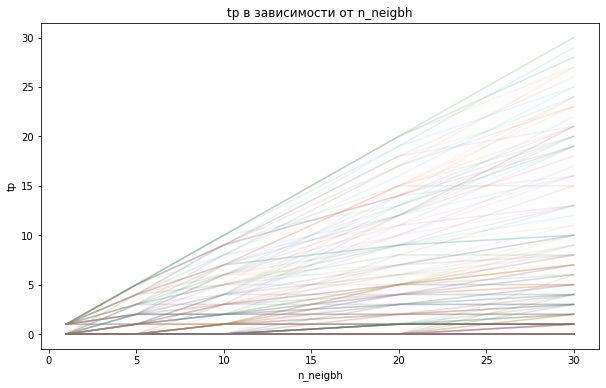

In [46]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["tp"], alpha=0.1)
plt.plot()
plt.title("tp в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("tp")
plt.show()

In [47]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.168196
5     0.151682
10    0.152599
20    0.150306
30    0.145362
Name: accuracy, dtype: float64

In [48]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.061111
5     0.051111
10    0.051111
20    0.048333
30    0.045741
Name: accuracy, dtype: float64

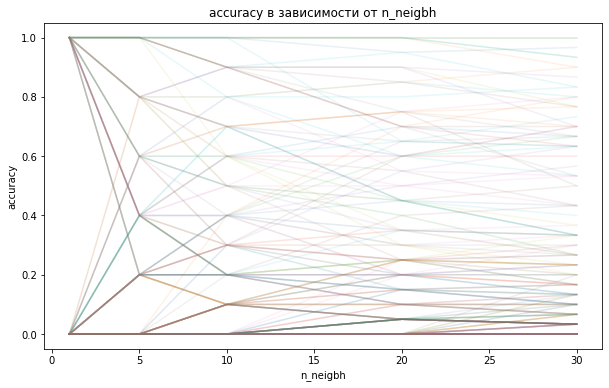

In [49]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["accuracy"], alpha=0.1)
plt.plot()
plt.title("accuracy в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("accuracy")
plt.show()

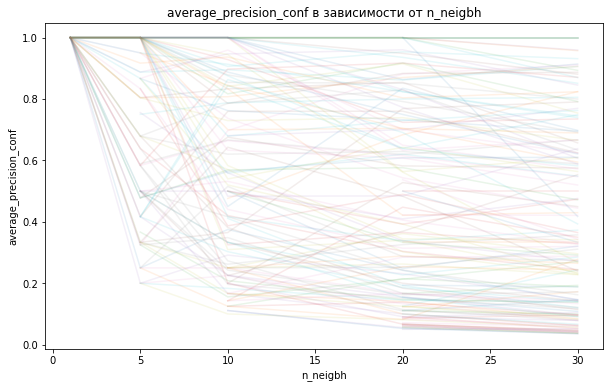

In [50]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_conf"], alpha=0.1)
plt.plot()
plt.title("average_precision_conf в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_conf")
plt.show()

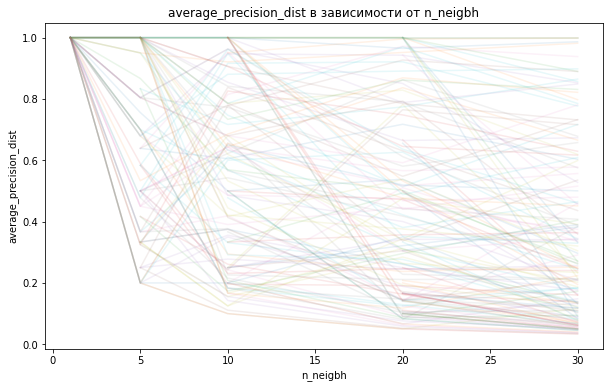

In [51]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_dist"], alpha=0.1)
plt.plot()
plt.title("average_precision_dist в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_dist")
plt.show()

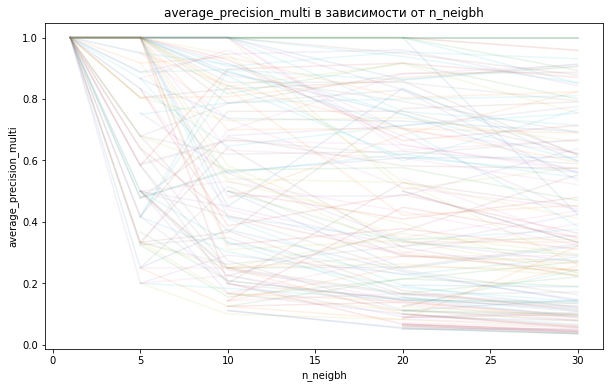

In [52]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_multi"], alpha=0.1)
plt.plot()
plt.title("average_precision_multi в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_multi")
plt.show()

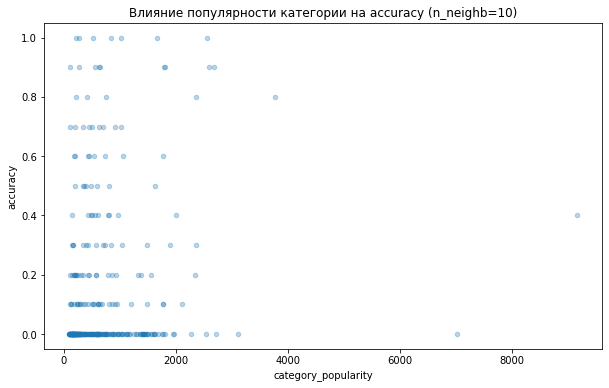

In [53]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на accuracy (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

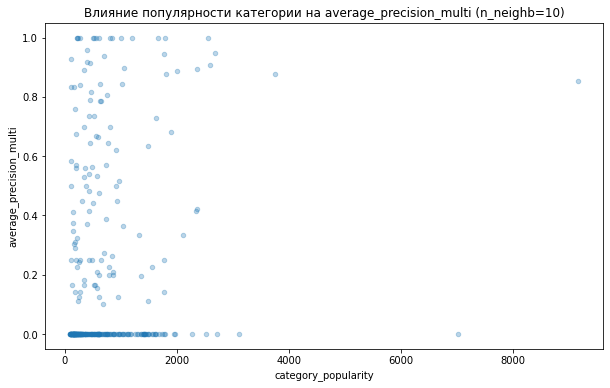

In [54]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

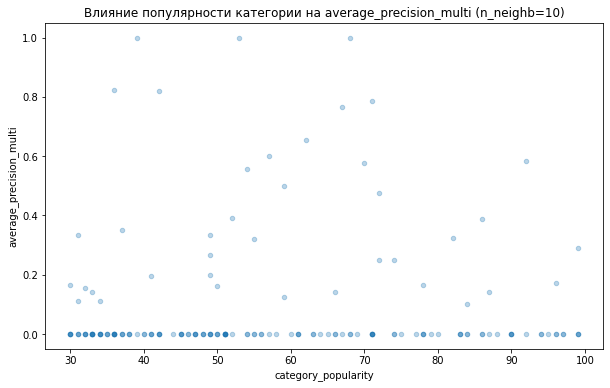

In [55]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

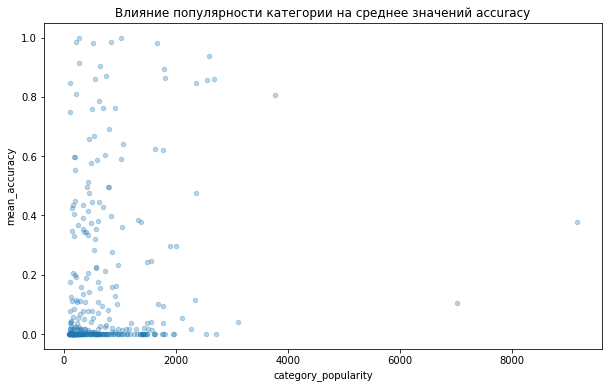

In [56]:
(
    metrics[metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .groupby(["category_id", "category_popularity"])["accuracy"]
    .mean()
    .reset_index(name="mean_accuracy")
    .plot(
        "category_popularity",
        "mean_accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на среднее значений accuracy",
        figsize=(10, 6),
    )
)
plt.show()

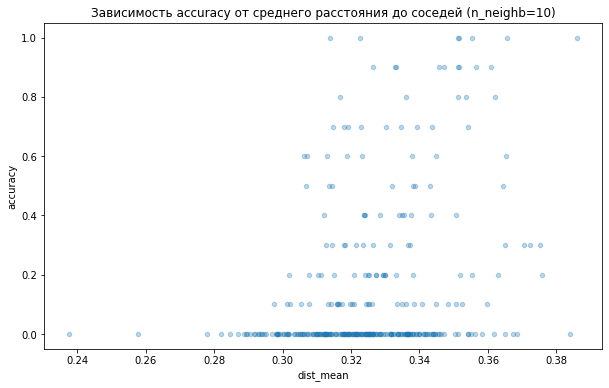

In [57]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "dist_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего расстояния до соседей (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

In [58]:
# top категорий по минимальному расстоянию до соседей (что хорошо знает clip)
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].sort_values("dist_mean").head(
    10
)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
5772,1155,wall_socket,10,NaN,NaN,...,0,0.237711,0.194867,NaN,0.0
3962,793,person,10,NaN,NaN,...,0,0.257670,0.544165,NaN,0.0
2042,409,earphone,10,NaN,NaN,...,0,0.278006,0.149992,NaN,0.0
5582,1117,tray,10,NaN,NaN,...,0,0.282005,0.251149,NaN,0.0
632,127,book,10,NaN,NaN,...,0,0.284731,0.238811,NaN,0.0
3222,645,lightbulb,10,NaN,NaN,...,0,0.287044,0.223787,NaN,0.0
2142,429,fan,10,NaN,NaN,...,0,0.288739,0.411912,NaN,0.0
3292,659,magnet,10,NaN,NaN,...,0,0.289328,0.158208,NaN,0.0
4172,835,poster,10,NaN,NaN,...,0,0.289612,0.185135,NaN,0.0
1387,278,coat_hanger,10,NaN,NaN,...,0,0.290449,0.144222,NaN,0.0


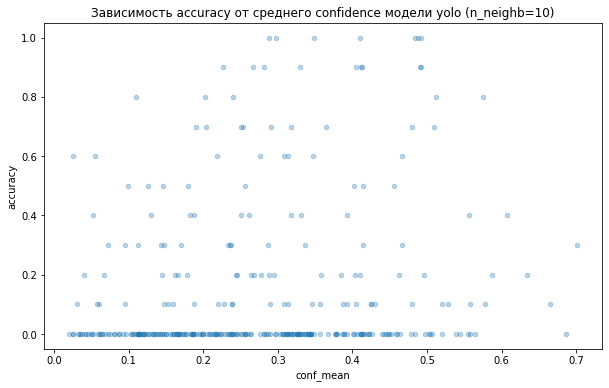

In [59]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

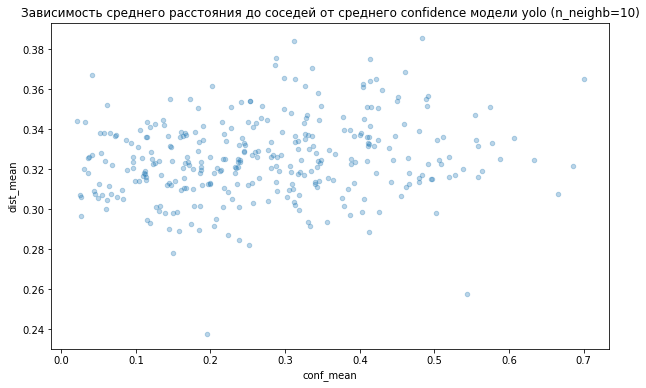

In [60]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "dist_mean",
        kind="scatter",
        alpha=0.3,
        title="Зависимость среднего расстояния до соседей от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

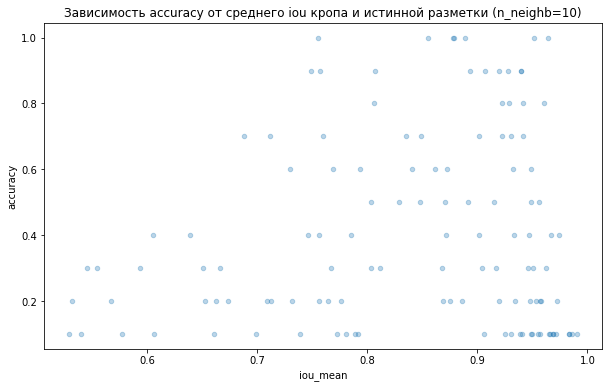

In [61]:
(
    metrics[
        (metrics["tp"] != 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
    ].plot(
        "iou_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего iou кропа и истинной разметки (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()